In [1]:
# Justin Hawk
# 11/7/2025
# 3DFENNEC_mlCode.ipynb
# Integrating the 3D data into the working 2DFENNEC_mlCode.ipynb

import fennec_ml as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import json
from torch.utils.data import TensorDataset, DataLoader
import glob
import re

# --- FOLDER CONFIG ---
data_dir = os.path.join(os.getcwd(), "testing_data")
os.makedirs(data_dir, exist_ok=True)
#excel_dir = os.path.join(data_dir, "raw_2D_data")
#os.makedirs(excel_dir, exist_ok=True)
#csv_dir = os.path.join(data_dir, "processed_data")
#os.makedirs(csv_dir, exist_ok=True)

excel_dir = r"C:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\DATA\raw_3D_data"
csv_dir = r"C:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\DATA\processed_data"

print("Current working directory:", os.getcwd())
print("Excel dir:", excel_dir)
print(csv_dir)
print(os.path.exists(csv_dir))
print("Does Excel dir exist?", os.path.exists(excel_dir))
print("Files in Excel dir:", os.listdir(excel_dir))

# --- MAKE VARS OF INTEREST ---
base_dir = os.getcwd()
json_path = os.path.join(base_dir, "3D_vars_of_interest.json")

# Data to write
vars_of_interest = {
    "IMU_0": ['GyrX', 'GyrY', 'GyrZ', 'AccX', 'AccY', 'AccZ'],
    "RCOU": ['C1','C2','C3','C4'],
    "ATT": ["DesYaw", "Yaw", "DesRoll", "Roll"],
}

#"RATE": ["R","P", "Y", "A"]

# Write to JSON file
with open(json_path, "w") as f:
    json.dump(vars_of_interest, f, indent=4)

print(f"Created {json_path}")

Current working directory: c:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\FENNEC_3D_Code
Excel dir: C:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\DATA\raw_3D_data
C:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\DATA\processed_data
True
Does Excel dir exist? True
Files in Excel dir: ['152B_BBB_L_1.xlsx', '153B_BBB_L_2.xlsx', '153G_BBB_L_3.xlsx', '154G_BBB_L_4.xlsx', '155G_AAA_L_1.xlsx', '156G_AAA_L_2.xlsx', '157G_AAA_L_3.xlsx', '158G_AAA_L_4.xlsx', '159G_BAA_L_1.xlsx', '160G_BAA_L_2.xlsx', '161G_BAA_L_3.xlsx', '162G_BAA_L_4.xlsx', '163G_CAA_L_1.xlsx', '164G_CAA_L_2.xlsx']
Created c:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\FENNEC_3D_Code\3D_vars_of_interest.json


In [2]:
# --- IMPORT FENNEC-ML --- 
import fennec_ml as fn # note the underscore

# --- EXCEL TO CSV ---
print("Using folder_cleaner() to convert from raw excel files to useful .csv's.\nfolder_cleaner() output:")

print("Running folder_cleaner...")
fn.folder_cleaner(excel_dir, csv_dir, overwrite= True, varspath="3D_vars_of_interest.json", downsample=False)
#downsample=False - Need to add
print("folder_cleaner finished")

Using folder_cleaner() to convert from raw excel files to useful .csv's.
folder_cleaner() output:
Running folder_cleaner...
Sheet RCOU, upsampled by 40.0
152B_BBB_L_1.xlsx processed and saved to C:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\DATA\processed_data as 152B_BBB_L_1.csv
Sheet RCOU, upsampled by 40.0
153B_BBB_L_2.xlsx processed and saved to C:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\DATA\processed_data as 153B_BBB_L_2.csv
Sheet RCOU, upsampled by 5.0
153G_BBB_L_3.xlsx processed and saved to C:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\DATA\processed_data as 153G_BBB_L_3.csv
Sheet RCOU, upsampled by 5.0
154G_BBB_L_4.xlsx processed and saved to C:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\DATA\processed_data as 154G_BBB_L_4.csv
Sheet RCOU, upsampled by 5.0
155G_AAA_L_1.xlsx processed and saved to C:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\DATA\processed_data as 155G_AAA_L_1.csv
Sheet RCOU, upsampled by 5.0
156G_AAA_L_2.xlsx processed and saved to C:\Project_FENNEC\FENNEC-25_26\Justin_H

In [3]:
print("Current working directory:", os.getcwd())
print("Raw Excel files:", os.listdir(excel_dir))
print("CSV folder contents:", os.listdir(csv_dir))

Current working directory: c:\Project_FENNEC\FENNEC-25_26\Justin_Hawk\FENNEC_3D_Code
Raw Excel files: ['152B_BBB_L_1.xlsx', '153B_BBB_L_2.xlsx', '153G_BBB_L_3.xlsx', '154G_BBB_L_4.xlsx', '155G_AAA_L_1.xlsx', '156G_AAA_L_2.xlsx', '157G_AAA_L_3.xlsx', '158G_AAA_L_4.xlsx', '159G_BAA_L_1.xlsx', '160G_BAA_L_2.xlsx', '161G_BAA_L_3.xlsx', '162G_BAA_L_4.xlsx', '163G_CAA_L_1.xlsx', '164G_CAA_L_2.xlsx']
CSV folder contents: ['152B_BBB_L_1.csv', '153B_BBB_L_2.csv', '153G_BBB_L_3.csv', '154G_BBB_L_4.csv', '155G_AAA_L_1.csv', '156G_AAA_L_2.csv', '157G_AAA_L_3.csv', '158G_AAA_L_4.csv', '159G_BAA_L_1.csv', '160G_BAA_L_2.csv', '161G_BAA_L_3.csv', '162G_BAA_L_4.csv', '163G_CAA_L_1.csv', '164G_CAA_L_2.csv']


In [ ]:
from utils.label_utils import get_3D_CG_labels

# Offsets applied to data
OFFSETS = [0,0,0,0.5,0,9.805507967592,0,0,0,0,0,0,0]
# --- SCALING AND LABELS ---
# scaled_data = fn.standardize(csv_dir)
scaled_data = fn.normalize(csv_dir)
labels = get_3D_CG_labels(csv_dir)

# --- SEGMENTING AND SPLITTING ---
print("\nUsing segment_and_split() to cut data into training/validtion/testing sets\nsegment_and_split() output:")
# using default 70%/15%/15% train/val/test split
dataset_dict = fn.segment_and_split(scaled_data, labels, timesteps=10)



Using segment_and_split() to cut data into training/validtion/testing sets
segment_and_split() output:
All data segmented and sorted!
Training_Sets: 3060
Validation_Sets: 656
Testing_Sets: 656


Labels

In [81]:
X_train = torch.tensor(dataset_dict["Training_Set"]["sets"], dtype=torch.float32)
X_val   = torch.tensor(dataset_dict["Validation_Set"]["sets"], dtype=torch.float32)
X_test  = torch.tensor(dataset_dict["Testing_Set"]["sets"], dtype=torch.float32)

# Define all possible labels

# all_labels = ["AAA", "AAB", "AAC",
# "ABA", "ABB", "ABC",
# "ACA", "ACB", "ACC",
# "BAA", "BAB", "BAC",
# "BBA", "BBB", "BBC",
# "BCA", "BCB", "BCC",
# "CAA", "CAB", "CAC",
# "CBA", "CBB", "CBC",
# "CCA", "CCB", "CCC"]

#For 4 class classification model
all_labels = ["AAA","BBB","BAA","CAA"]

# Create a consistent mapping
label_to_idx = {label: i for i, label in enumerate(all_labels)}
print("Label mapping:", label_to_idx)

# Create a reverse index for plotting later in function
idx_to_label = {i: label for label, i in label_to_idx.items()}
print("Reverse label mapping: ", idx_to_label)

# Function to convert string labels to integers
def convert_labels(label_array):
    return torch.tensor([label_to_idx[l] for l in label_array], dtype=torch.long)

# Apply to all splits
y_train = convert_labels(dataset_dict["Training_Set"]["labels"])
y_val   = convert_labels(dataset_dict["Validation_Set"]["labels"])
y_test  = convert_labels(dataset_dict["Testing_Set"]["labels"])

Label mapping: {'AAA': 0, 'BBB': 1, 'BAA': 2, 'CAA': 3}
Reverse label mapping:  {0: 'AAA', 1: 'BBB', 2: 'BAA', 3: 'CAA'}


Model

In [82]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout, bidirectional=True):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )

        #Fully connected (classification) head
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)

        # LSTM output
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, timesteps, hidden_size * num_directions)

        # Take the last time step
        out = out[:, -1, :]  # (batch_size, hidden_size * num_directions)

        # Fully connected layers
        out = self.fc(out)   # (batch_size, num_classes)
        return out

Data Loader

In [83]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

Model Setup

In [84]:
input_size = 14
hidden_size = 128
num_layers = 3
#change this for binary classification model test
#num_classes = 27
num_classes = 4
epochs = 100
dropout = 0.32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_3DCG = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout,
                            bidirectional=True).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3DCG.parameters(), lr=0.001, weight_decay=1e-5)

In [85]:
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

# Also check number of batches:
print(f"Train batches per epoch: {len(train_loader)}")

len(train_loader)

Train dataset size: 3060
Validation dataset size: 656
Test dataset size: 656
Train batches per epoch: 96


96

In [92]:
for X_batch, y_batch in train_loader:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break  # just look at the first batch


X_batch shape: torch.Size([32, 10, 14])
y_batch shape: torch.Size([32])


Training

In [86]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

best_val_acc = 0.0
best_val_loss = float("inf")

for epoch in range(epochs):
    model_3DCG.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_3DCG(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)

    # Validation
    model_3DCG.eval()
    val_total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_3DCG(X_batch)

            loss = loss_fn(outputs, y_batch)
            val_total_loss += loss.item() * X_batch.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_total_loss/len(val_loader.dataset)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")
    
        # ------------------ Save Best Model ------------------ #
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"{save_dir}/best_model_loss.pth"
        torch.save(model_3DCG.state_dict(), best_model_path)
        print(f"✅ Best model saved (Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f})")

Epoch [1/100] | Train Loss: 1.2346 | Val Loss: 1.1906 | Val Acc: 0.3948
✅ Best model saved (Epoch 1, Val Loss: 1.1906)
Epoch [2/100] | Train Loss: 1.1797 | Val Loss: 1.1924 | Val Acc: 0.4101
Epoch [3/100] | Train Loss: 1.1634 | Val Loss: 1.1150 | Val Acc: 0.4771
✅ Best model saved (Epoch 3, Val Loss: 1.1150)
Epoch [4/100] | Train Loss: 1.0995 | Val Loss: 1.0609 | Val Acc: 0.5259
✅ Best model saved (Epoch 4, Val Loss: 1.0609)
Epoch [5/100] | Train Loss: 1.0649 | Val Loss: 1.0225 | Val Acc: 0.5473
✅ Best model saved (Epoch 5, Val Loss: 1.0225)
Epoch [6/100] | Train Loss: 1.0166 | Val Loss: 1.0120 | Val Acc: 0.5564
✅ Best model saved (Epoch 6, Val Loss: 1.0120)
Epoch [7/100] | Train Loss: 0.9768 | Val Loss: 1.1040 | Val Acc: 0.5137
Epoch [8/100] | Train Loss: 0.9676 | Val Loss: 0.9113 | Val Acc: 0.6082
✅ Best model saved (Epoch 8, Val Loss: 0.9113)
Epoch [9/100] | Train Loss: 0.9072 | Val Loss: 0.9003 | Val Acc: 0.6174
✅ Best model saved (Epoch 9, Val Loss: 0.9003)
Epoch [10/100] | Train 

Graphs

In [34]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# classes = ["AAA", "AAB", "AAC",
# "ABA", "ABB", "ABC",
# "ACA", "ACB", "ACC",
# "BAA", "BAB", "BAC",
# "BBA", "BBB", "BBC",
# "BCA", "BCB", "BCC",
# "CAA", "CAB", "CAC",
# "CBA", "CBB", "CBC",
# "CCA", "CCB", "CCC"]

classes = ["AAA","BBB","BAA","CAA"]

def plot_confusion_and_confidence(model_3DCG, loader, classes, device="cpu"):
    model_3DCG.to(device)
    model_3DCG.eval()

    all_true = []
    all_preds = []
    all_probs = []
    all_confidences = []

    # ---- Step 1: Gather predictions ---- #
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model_3DCG(X_batch)
            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)

            all_true.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_confidences.extend(confs.cpu().numpy())

    all_true = np.array(all_true)
    all_preds = np.array(all_preds)
    all_confidences = np.array(all_confidences)

    # ---- Step 2: Compute accuracy ---- #
    accuracy = np.mean(all_true == all_preds)
    print(f"Test Accuracy: {accuracy:.2%}")

    # ---- Step 3: Confusion Matrix ---- #
    cm = confusion_matrix(all_true, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', values_format=".2f")
    plt.title("Normalized Confusion Matrix (rows sum to 100%)")
    plt.show()

    # ---- Step 4: Average Confidence Matrix ---- #
    n_classes = len(classes)
    conf_matrix = np.zeros((n_classes, n_classes))

    for t, p, c in zip(all_true, all_preds, all_confidences):
        conf_matrix[t, p] += c

    counts = np.bincount(all_true, minlength=n_classes)
    conf_matrix = conf_matrix / counts[:, None]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Average Confidence per True–Predicted Class")
    plt.show()

Test Accuracy: 92.75%


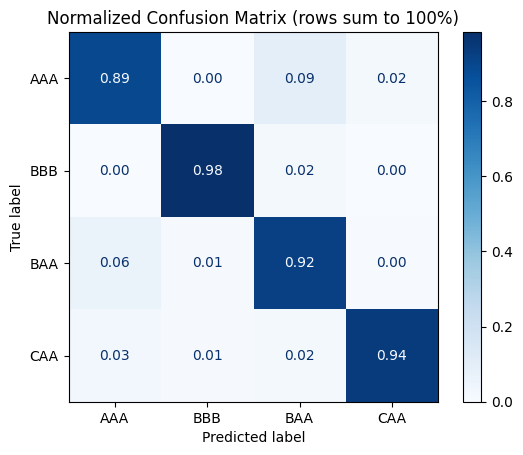

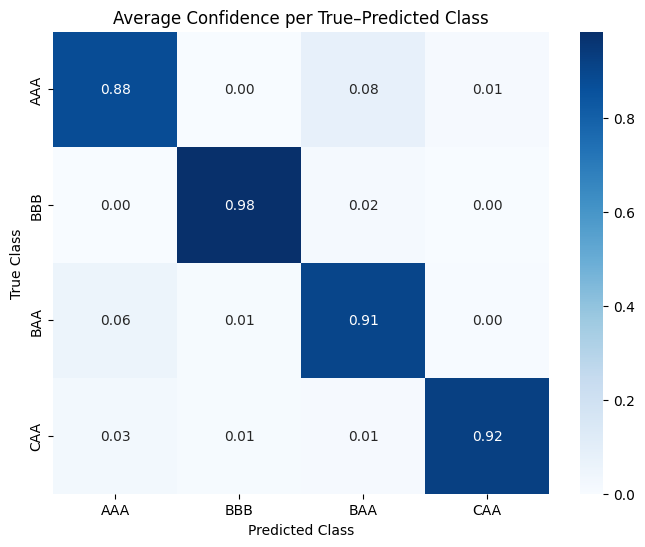

In [61]:
plot_confusion_and_confidence(model_3DCG, test_loader, classes, device=device)

Single Never Before Seen Flight Prediction

In [87]:
import torch
from torch.utils.data import Dataset 
import pandas as pd
import numpy as np
import os

class SingleFlightDataset(Dataset):
    def __init__(self, csv_path, label_map):
        self.csv_path = csv_path
        self.label_map = label_map

        # Load full CSV → (seq_len, features)
        df = pd.read_csv(csv_path)
        self.sequence = df.to_numpy(dtype=np.float32)

        # Get label from filename
        filename = os.path.basename(csv_path)
        parts = filename.split("_")
        label_str = parts[1]      # e.g. 154G_BBB_L_4 → BBB
        self.label = label_map[label_str]

    def __len__(self):
        return 1     # one flight = one sample

    def __getitem__(self, idx):
        X = torch.tensor(self.sequence)       # (seq_len, input_size)
        y = torch.tensor(self.label)
        return X, y


In [88]:
csv_path = "individual_testflight/153B_BBB_L_2.csv"
dataset = SingleFlightDataset(csv_path, label_map=label_to_idx)
loader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [ ]:
model_3DCG.eval()
model_3DCG.to(device)

with torch.no_grad():
    for X, y in loader:
        X = X.to(device)   # (1, seq_len, input_size)
        y = y.to(device)

        outputs = model_3DCG(X)              # logits
        probs = torch.softmax(outputs, dim=1)

        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_class].item()

        print("True class:", idx_to_label[y.item()])
        print("Predicted class:", idx_to_label[pred_class])
        print(f"Confidence: {confidence:.4f}\n")

        print("Class probabilities:")
        for i, p in enumerate(probs.squeeze()):
            print(f"{idx_to_label[i]}: {p:.4f}")



True class: BBB
Predicted class: AAA
Confidence: 0.9008

Class probabilities:
AAA: 0.9008
BBB: 0.0003
BAA: 0.0096
CAA: 0.0893


In [90]:
print("Sequence shape:", X.shape)

Sequence shape: torch.Size([1, 2063, 14])


input_size = 14
hidden_size = 128
num_layers = 3
#change this for binary classification model test
#num_classes = 27
num_classes = 4
epochs = 100
dropout = 0.3

- 91% accuracy - 92% with 200 Epochs



input_size = 14
hidden_size = 128
num_layers = 3
#change this for binary classification model test
#num_classes = 27
num_classes = 4
epochs = 100
dropout = 0.32

- 90.5% accuracy 100 epochs - 92% 200 Epochs - 93.5%?

input_size = 14
hidden_size = 128
num_layers = 4
#change this for binary classification model test
#num_classes = 27
num_classes = 4
epochs = 100
dropout = 0.32

- 91.62% - 100 Epochs -- 